# 1.8k: Tetrahedral Faces

From 1.8j we saw the 4 black holes form a tetrahedron in 3D. But it's lopsided—not a regular tetrahedron with equilateral triangles.

**Question:** What do the 4 faces actually look like?

**Method:**
1. A tetrahedron has 4 triangular faces (one for each combination of 3 vertices)
2. For each face, project the 3 vertices onto the 2D plane they define
3. Plot as a 2D triangle with vertices color-coded
4. Annotate with edge lengths

This reveals the exact shape of each face—whether they're equilateral, isosceles, scalene, etc.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from safetensors.torch import load_file
from pathlib import Path
from itertools import combinations

## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [4]:
# Load W in bfloat16
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]

print(f"Loaded W: {W_bf16.shape}")

Loaded W: torch.Size([151936, 2560])


In [5]:
# Load black hole data
bh_path = Path(f"../tensors/{MODEL_NAME}/1.8e_black_hole_masks.safetensors")
bh_data = load_file(bh_path)

bh1_token_ids = bh_data["bh1_token_ids"].to(torch.int64)
bh2_token_ids = bh_data["bh2_token_ids"].to(torch.int64)
bh3_token_ids = bh_data["bh3_token_ids"].to(torch.int64)
bh4_token_ids = bh_data["bh4_token_ids"].to(torch.int64)

print(f"\nLoaded black holes:")
print(f"  BH1: {len(bh1_token_ids):,} tokens")
print(f"  BH2: {len(bh2_token_ids):,} tokens")
print(f"  BH3: {len(bh3_token_ids):,} tokens")
print(f"  BH4: {len(bh4_token_ids):,} tokens")


Loaded black holes:
  BH1: 866 tokens
  BH2: 734 tokens
  BH3: 329 tokens
  BH4: 249 tokens


## Extract Black Hole Representative Vectors

In [6]:
print("\nExtracting black hole representative vectors...\n")

# Get first token from each black hole as representative
bh_token_ids = [
    bh1_token_ids[0].item(),
    bh2_token_ids[0].item(),
    bh3_token_ids[0].item(),
    bh4_token_ids[0].item()
]

# Get vectors from W (float32 for numerical stability)
bh_vectors = []
for i, token_id in enumerate(bh_token_ids, 1):
    vector = W_bf16[token_id].to(torch.float32)
    bh_vectors.append(vector)
    print(f"BH{i}: Token {token_id}")

# Stack into matrix (4 × 2560)
bh_matrix = torch.stack(bh_vectors, dim=0)

print(f"\n✓ Extracted {len(bh_vectors)} representative vectors")


Extracting black hole representative vectors...

BH1: Token 80091
BH2: Token 125
BH3: Token 124
BH4: Token 123939

✓ Extracted 4 representative vectors


## Project to 3D (from 1.8j)

In [7]:
print("\nProjecting to 3D...\n")

# Center the data
mean_vector = bh_matrix.mean(dim=0)
centered_matrix = bh_matrix - mean_vector

# Compute SVD
U, S, Vt = torch.linalg.svd(centered_matrix, full_matrices=False)

# Project onto top 3 principal components
projection_matrix = Vt[:3, :].T
coords_3d = centered_matrix @ projection_matrix  # Shape: (4, 3)

print("3D coordinates:")
for i, (x, y, z) in enumerate(coords_3d, 1):
    print(f"  BH{i}: ({x.item():+.4e}, {y.item():+.4e}, {z.item():+.4e})")

print(f"\n✓ Projected to 3D")


Projecting to 3D...

3D coordinates:
  BH1: (-1.4986e-05, +8.0409e-06, +4.8876e-06)
  BH2: (+1.2782e-05, -1.1761e-05, +3.4004e-06)
  BH3: (+1.9052e-05, +9.2894e-06, -3.0601e-06)
  BH4: (-1.6848e-05, -5.5697e-06, -5.2278e-06)

✓ Projected to 3D


## Define the 4 Faces

In [8]:
# A tetrahedron has 4 faces (each is a combination of 3 vertices)
faces = [
    (0, 1, 2),  # BH1, BH2, BH3
    (0, 1, 3),  # BH1, BH2, BH4
    (0, 2, 3),  # BH1, BH3, BH4
    (1, 2, 3),  # BH2, BH3, BH4
]

face_names = [
    "Face 1: BH1-BH2-BH3",
    "Face 2: BH1-BH2-BH4",
    "Face 3: BH1-BH3-BH4",
    "Face 4: BH2-BH3-BH4",
]

print(f"\nTetrahedron has {len(faces)} faces:")
for name in face_names:
    print(f"  {name}")


Tetrahedron has 4 faces:
  Face 1: BH1-BH2-BH3
  Face 2: BH1-BH2-BH4
  Face 3: BH1-BH3-BH4
  Face 4: BH2-BH3-BH4


## Project Each Face to 2D and Visualize


Projecting faces to 2D and visualizing...



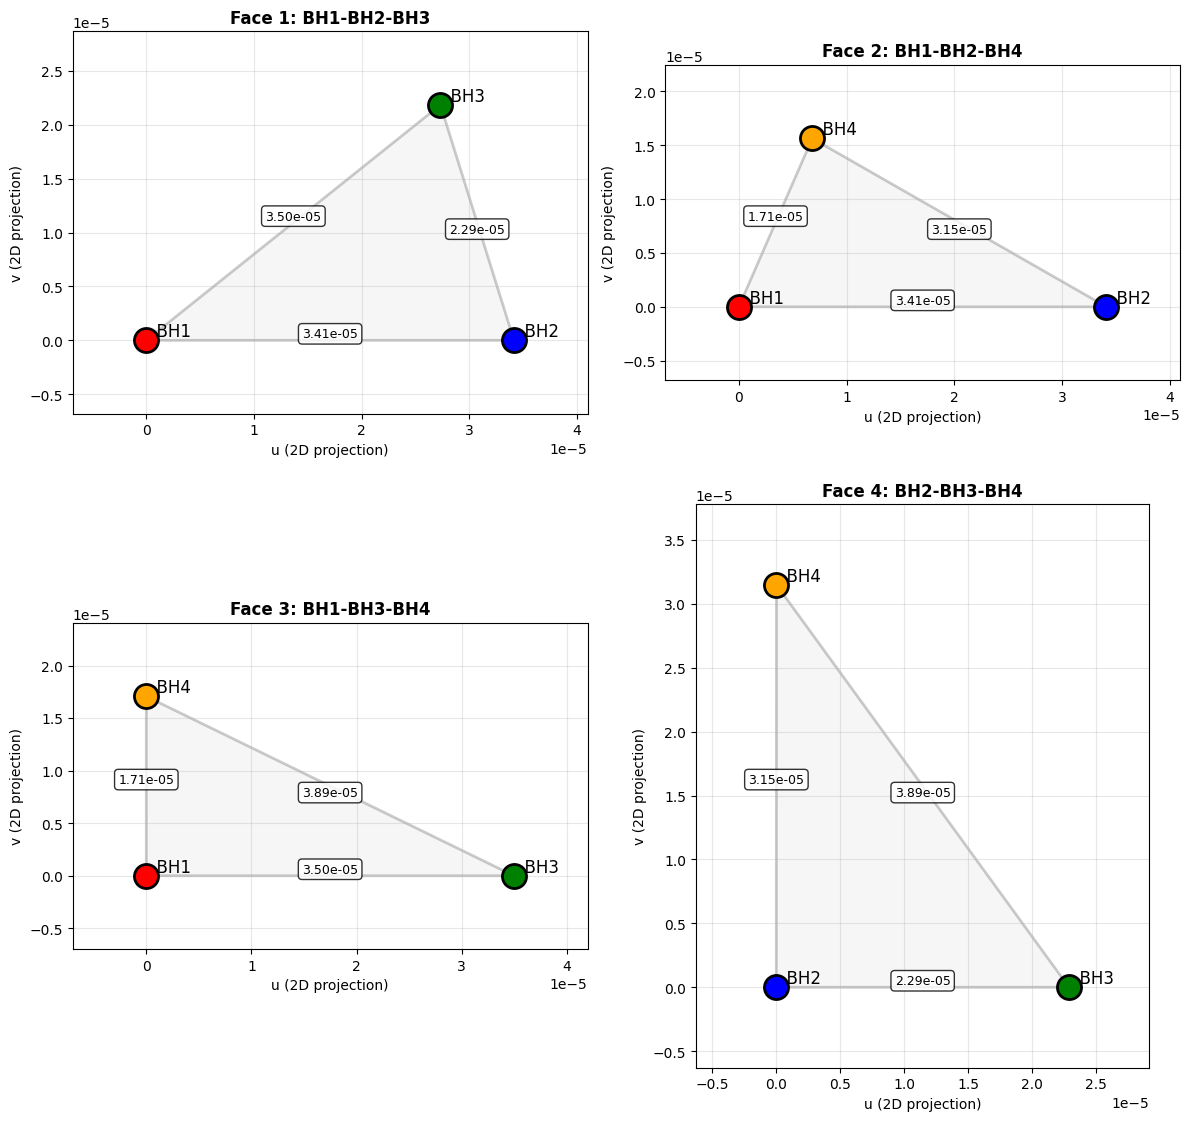

✓ Visualization complete


In [15]:
print("\nProjecting faces to 2D and visualizing...\n")

# Colors and labels
colors = ['red', 'blue', 'green', 'orange']
bh_labels = ['BH1', 'BH2', 'BH3', 'BH4']

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=100)
axes = axes.flatten()

for face_idx, (face, face_name) in enumerate(zip(faces, face_names)):
    ax = axes[face_idx]
    
    # Extract the 3 vertices for this face (in 3D)
    v0 = coords_3d[face[0]]
    v1 = coords_3d[face[1]]
    v2 = coords_3d[face[2]]
    
    # Create 2D basis for the plane containing these 3 points
    # Use two edge vectors
    edge1 = v1 - v0
    edge2 = v2 - v0
    
    # Gram-Schmidt orthonormalization
    u = edge1 / torch.norm(edge1)  # First basis vector (normalized edge1)
    
    # Project edge2 onto u and subtract to get perpendicular component
    edge2_perp = edge2 - (edge2 @ u) * u
    v = edge2_perp / torch.norm(edge2_perp)  # Second basis vector (normalized, perpendicular to u)
    
    # Project the 3 vertices onto (u, v) basis
    # v0 is the origin in 2D
    coords_2d = []
    for vertex in [v0, v1, v2]:
        displacement = vertex - v0
        x = (displacement @ u).item()
        y = (displacement @ v).item()
        coords_2d.append((x, y))
    
    # Extract 2D coordinates
    xs = [c[0] for c in coords_2d]
    ys = [c[1] for c in coords_2d]
    
    # Compute edge lengths (in original 3D space)
    edge_01 = torch.norm(v1 - v0).item()
    edge_02 = torch.norm(v2 - v0).item()
    edge_12 = torch.norm(v2 - v1).item()
    
    # Draw filled triangle
    triangle = Polygon(coords_2d, alpha=0.2, facecolor='lightgray', edgecolor='black', linewidth=2)
    ax.add_patch(triangle)
    
    # Plot vertices
    for i, (x, y, vertex_idx) in enumerate(zip(xs, ys, face)):
        ax.scatter([x], [y], s=300, c=colors[vertex_idx], edgecolors='black', 
                   linewidths=2, zorder=10, label=bh_labels[vertex_idx])
        ax.text(x, y, f"  {bh_labels[vertex_idx]}", fontsize=12, ha='left', va='bottom')
    
    # Annotate edge lengths
    # Edge 0-1
    mid_01 = ((xs[0] + xs[1]) / 2, (ys[0] + ys[1]) / 2)
    ax.text(mid_01[0], mid_01[1], f"{edge_01:.2e}", fontsize=9, 
            ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Edge 0-2
    mid_02 = ((xs[0] + xs[2]) / 2, (ys[0] + ys[2]) / 2)
    ax.text(mid_02[0], mid_02[1], f"{edge_02:.2e}", fontsize=9, 
            ha='center', va='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Edge 1-2
    mid_12 = ((xs[1] + xs[2]) / 2, (ys[1] + ys[2]) / 2)
    ax.text(mid_12[0], mid_12[1], f"{edge_12:.2e}", fontsize=9, 
            ha='center', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Classify triangle type
    edges = sorted([edge_01, edge_02, edge_12])
    tol = 1e-6
    
    if abs(edges[0] - edges[2]) < tol:
        tri_type = "Equilateral"
    elif abs(edges[0] - edges[1]) < tol or abs(edges[1] - edges[2]) < tol:
        tri_type = "Isosceles"
    else:
        tri_type = "Scalene"
    
    # Styling
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"{face_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel('u (2D projection)', fontsize=10)
    ax.set_ylabel('v (2D projection)', fontsize=10)
    
    # Add some padding
    x_range = max(xs) - min(xs)
    y_range = max(ys) - min(ys)
    padding = max(x_range, y_range) * 0.2
    ax.set_xlim(min(xs) - padding, max(xs) + padding)
    ax.set_ylim(min(ys) - padding, max(ys) + padding)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary: Face Analysis

In [16]:
print("\n" + "=" * 80)
print("SUMMARY: TETRAHEDRAL FACE ANALYSIS")
print("=" * 80)
print()

print("The tetrahedron has 4 triangular faces:")
print()

for face_idx, (face, face_name) in enumerate(zip(faces, face_names)):
    # Extract vertices
    v0 = coords_3d[face[0]]
    v1 = coords_3d[face[1]]
    v2 = coords_3d[face[2]]
    
    # Compute edge lengths
    edge_01 = torch.norm(v1 - v0).item()
    edge_02 = torch.norm(v2 - v0).item()
    edge_12 = torch.norm(v2 - v1).item()
    
    edges = sorted([edge_01, edge_02, edge_12])
    
    # Classify
    tol = 1e-6
    if abs(edges[0] - edges[2]) < tol:
        tri_type = "Equilateral"
    elif abs(edges[0] - edges[1]) < tol or abs(edges[1] - edges[2]) < tol:
        tri_type = "Isosceles"
    else:
        tri_type = "Scalene"
    
    print(f"{face_name}:")
    print(f"  Type: {tri_type}")
    print(f"  Edge lengths: {edge_01:.4e}, {edge_02:.4e}, {edge_12:.4e}")
    print()

print("The tetrahedron is IRREGULAR (not all faces are equilateral).")
print("This reflects the lopsided nature of the 4 black holes in 2560D space.")
print()
print("=" * 80)


SUMMARY: TETRAHEDRAL FACE ANALYSIS

The tetrahedron has 4 triangular faces:

Face 1: BH1-BH2-BH3:
  Type: Isosceles
  Edge lengths: 3.4137e-05, 3.4975e-05, 2.2894e-05

Face 2: BH1-BH2-BH4:
  Type: Scalene
  Edge lengths: 3.4137e-05, 1.7060e-05, 3.1476e-05

Face 3: BH1-BH3-BH4:
  Type: Scalene
  Edge lengths: 3.4975e-05, 1.7060e-05, 3.8914e-05

Face 4: BH2-BH3-BH4:
  Type: Scalene
  Edge lengths: 2.2894e-05, 3.1476e-05, 3.8914e-05

The tetrahedron is IRREGULAR (not all faces are equilateral).
This reflects the lopsided nature of the 4 black holes in 2560D space.

